In [1]:
import os
import sys
import boto3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from dotenv import load_dotenv

# defining functions module path
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import connect_to_redshift

In [2]:
# removing warning messages
warnings.filterwarnings("ignore")

In [3]:
# Loading my .env file
load_dotenv()

True

In [4]:
# defining redshift credentials
dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")

In [5]:
# establishing redshift connection
rs_connection = connect_to_redshift(dbname, host, port, user, password)

connection to redshift made


In [6]:
query = """select *
           from bootcamp.online_transactions_cleaned
        """

In [7]:
ot = pd.read_sql(query, rs_connection)

In [8]:
print(f"There are {ot.duplicated().sum()} duplicated rows in the dataset")

There are 0 duplicated rows in the dataset


In [9]:
print(ot.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399841 entries, 0 to 399840
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   invoice            399841 non-null  object        
 1   stock_code         399841 non-null  object        
 2   description        399841 non-null  object        
 3   price              399841 non-null  float64       
 4   quantity           399841 non-null  int64         
 5   total_order_value  399841 non-null  float64       
 6   invoice_date       399841 non-null  datetime64[ns]
 7   customer_id        399841 non-null  object        
 8   country            399841 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 27.5+ MB
None


In [10]:
ot.describe()

,price,quantity,total_order_value
count,399841.000000,399841.000000,399841.000000
mean,2.952914,12.224359,20.716904
std,7.317593,250.788860,425.471765
min,0.000000,-80995.000000,-168469.600000
25%,1.250000,2.000000,4.250000
50%,1.950000,5.000000,11.580000
75%,3.750000,12.000000,19.500000
max,1599.260000,80995.000000,168469.600000


In [11]:
ot.describe(include=object)

,invoice,stock_code,description,customer_id,country
count,399841,399841,399841,399841,399841
unique,21791,3679,3644,4363,37
top,576339,85123A,CREAM HANGING HEART T-LIGHT HOLDER,u17841,United Kingdom
freq,542,2065,2065,7800,356158


### Let's explore the outliers

<Axes: >

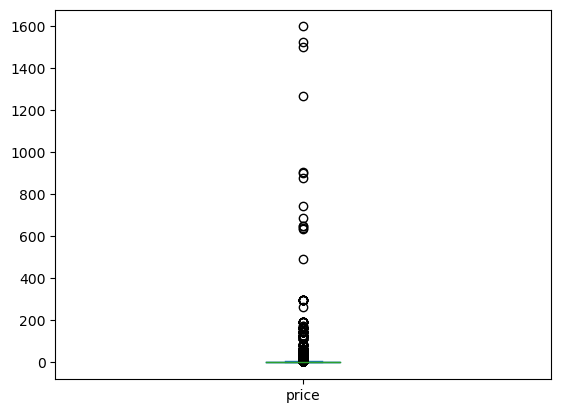

In [12]:
ot['price'].plot.box()

### It is clear that there are outliers on the price column. Let's check how many transactions are with price equal to zero

In [13]:
# Number of transactions with price equal to zero
n_price_zero = ot[ot['price'] == 0].shape[0]
print(f"There are {n_price_zero} transactions with price zero. That represents {round(n_price_zero * 100 / ot.shape[0], 2)} % of the data, therefore they are gonna be removed from the dataset.")

There are 34 transactions with price zero. That represents 0.01 % of the data, therefore they are gonna be removed from the dataset.


In [14]:
ot.drop(ot[ot['price'] == 0].index, axis=0, inplace=True)
ot.reset_index(inplace=True, drop=True)

In [15]:
# Let's start by exploring the outliers in the price column
_, mean_price, std_price, min_price, Q1_price, Q2_price, Q3_price, max_price = ot.price.describe()
IQR_price = Q3_price - Q1_price
low_lim_price = Q1_price - 1.5 * IQR_price
up_lim_price = Q3_price + 1.5 * IQR_price

Text(0.5, 23.52222222222222, 'Price (pounds)')

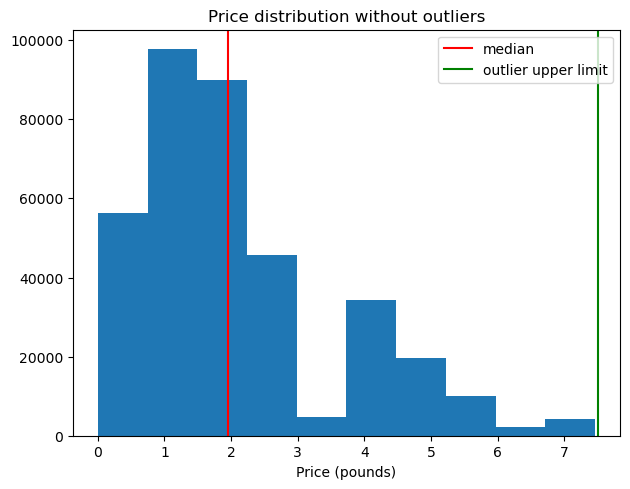

In [16]:
# Price histogram plotting
plt.hist(ot.price[ot['price'] < up_lim_price])
plt.axvline(x=Q2_price, color='red', label='median')
plt.axvline(x=up_lim_price, color='green', label='outlier upper limit')
plt.title("Price distribution without outliers")
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlabel('Price (pounds)')

In [17]:
outlier_perc = round(ot[ot['price'] >= up_lim_price].shape[0] * 100 / ot.shape[0], 2)
print(f"{outlier_perc} % of my data are outliers on the price variable")

8.75 % of my data are outliers on the price variable


### Let's explore seasonality in the data

In [26]:
# Setting up monthly, yearly, daily data
ot['invoice_year'] = ot['invoice_date'].dt.year
ot['invoice_month'] = ot['invoice_date'].dt.month
ot['invoice_weekday'] = ot['invoice_date'].dt.dayofweek
ot['invoice_dayname'] = ot['invoice_date'].dt.day_name()

In [19]:
# Defining color palette for plots
palette = sns.color_palette("tab10")

Text(0.5, 0, 'Month of the year')

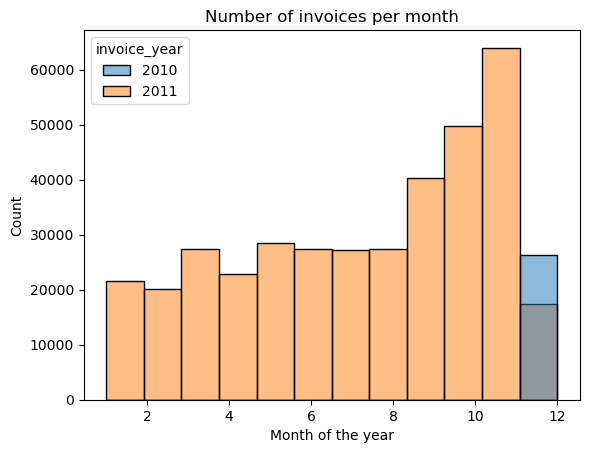

In [20]:
# Distribution of invoices per month
sns.histplot(data=ot, x='invoice_month', hue='invoice_year', bins=12, kde=False, palette=palette)
plt.title("Number of invoices per month")
plt.xlabel("Month of the year")

### The number of invoice has a boost from September on, having a peak on November (presumably because of Black Friday) reachig its lowest point on December 2011.

In [27]:
# To plot the days in order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ot['invoice_dayname'] = pd.Categorical(ot['invoice_date'].dt.day_name(), categories=day_order, ordered=True)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

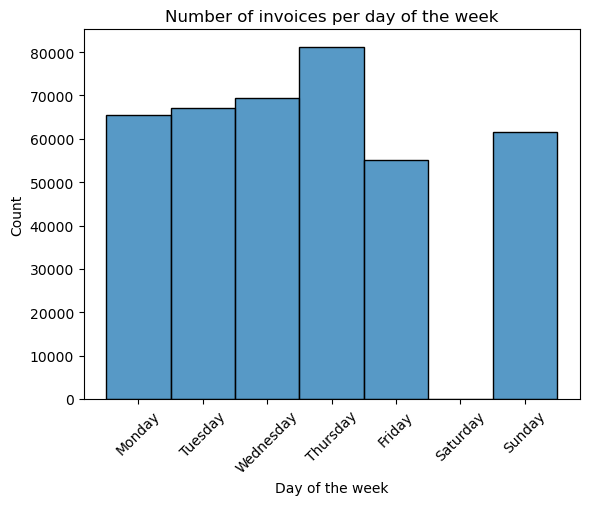

In [28]:
# Distributions of invoices per day of the week
sns.histplot(data=ot, x='invoice_dayname', multiple='stack', bins=12, kde=False)
plt.title("Number of invoices per day of the week")
plt.xlabel("Day of the week")
plt.xticks(rotation=45)

### The number of invoice has a peak on Thursdays. It is interesting that there is no data available for Saturdays

## Let's explore some KPIs

In [31]:
# Line Items (Number of products per invoice)
line_items = ot.groupby("invoice")['stock_code'].count()
print(f"On average, there are {round(line_items.mean())} stock codes per invoice")

On average, there are 18 stock codes per invoice


In [33]:
# Average order value per invoice
avg_order = ot.groupby("invoice").sum()['total_order_value']
print(f"The average purchase per invoice is {round(avg_order.mean(), 2)} pounds")

The average purchase per invoice is 380.18 pounds
